<a href="https://colab.research.google.com/github/prachyasuman2396-arch/next_day_log_return_app/blob/main/next_day_log_return.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from datetime import datetime

In [ ]:
ticker = "AAPL"
df = yf.download(
    ticker,
    start="2010-01-01",
    end=None,
    auto_adjust=False
)

[*********************100%***********************]  1 of 1 completed


In [ ]:
df.columns = [x[0] for x in df.columns]

In [ ]:
df.reset_index(inplace=True)


<Axes: xlabel='Date', ylabel='Close'>

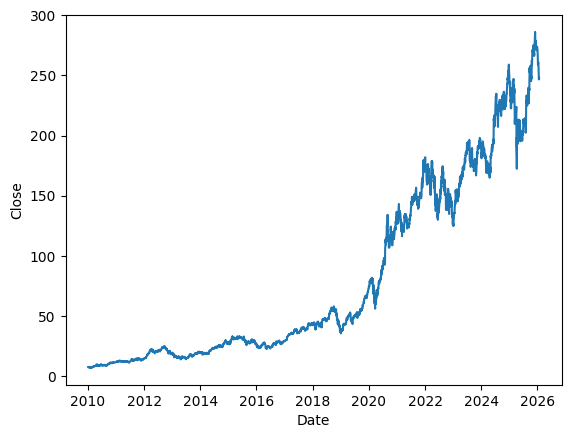

In [ ]:
import seaborn as sns
sns.lineplot(data=df, x="Date", y="Close")

In [ ]:
import numpy as np

df['log_return'] = np.log(df['Close'] / df['Close'].shift(1))
df.dropna(inplace=True)


<Axes: xlabel='Date', ylabel='log_return'>

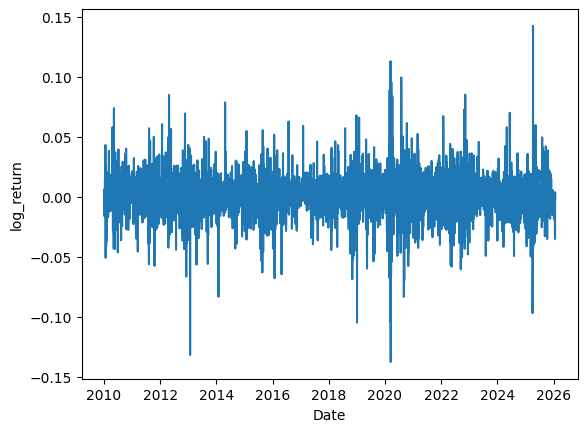

In [ ]:
sns.lineplot(data=df, x="Date", y="log_return")

In [ ]:
from statsmodels.tsa.stattools import adfuller

# ADF test on log returns
result = adfuller(df['log_return'])

print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Used lags:", result[2])
print("Number of observations:", result[3])

print("\nCritical Values:")
for key, value in result[4].items():
    print(f"   {key}: {value}")


ADF Statistic: -21.413411801660203
p-value: 0.0
Used lags: 8
Number of observations: 4029

Critical Values:
   1%: -3.4319740931217964
   5%: -2.8622576354797014
   10%: -2.567152004764292


this is statioanry

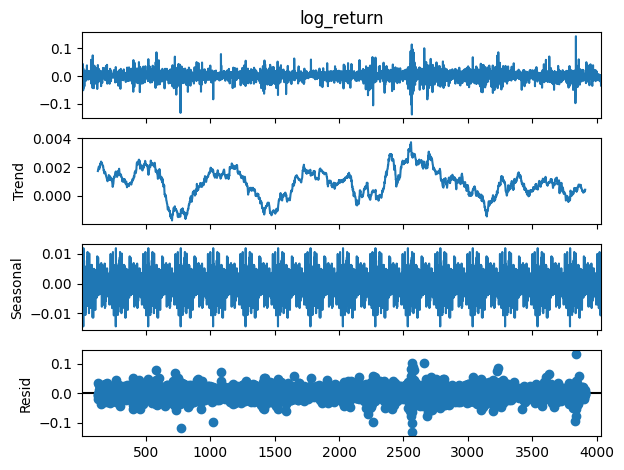

In [ ]:

from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose price series
decomp_price = seasonal_decompose(
    df['log_return'],
    model='additive',
    period=252  # ~1 trading year
)

decomp_price.plot()
plt.show()


no proper trend exist, seasonality is mechanical and it  also not imapacting more,resid has 0 mean but has veriance

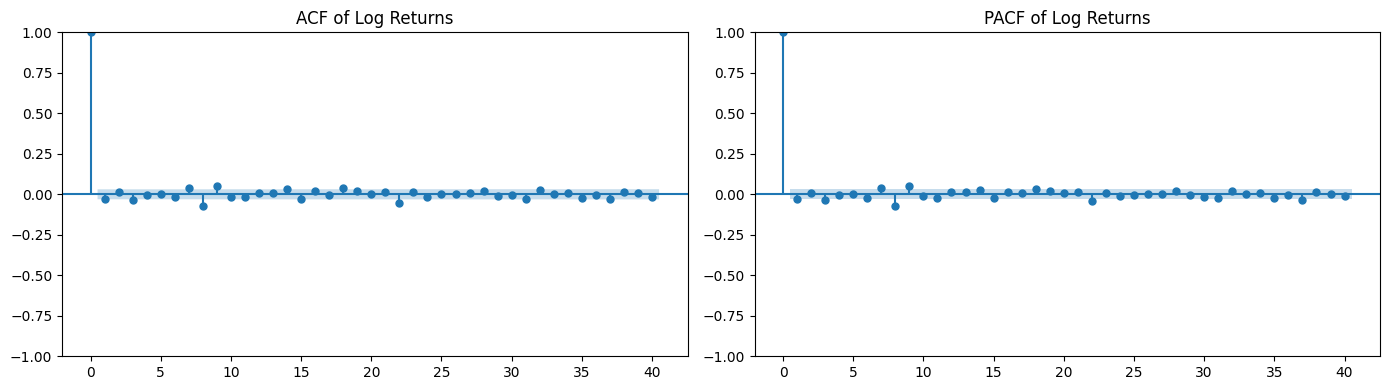

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# ACF & PACF on log returns
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

plot_acf(df['log_return'], lags=40, ax=axes[0])
axes[0].set_title("ACF of Log Returns")

plot_pacf(df['log_return'], lags=40, ax=axes[1], method='ywm')
axes[1].set_title("PACF of Log Returns")

plt.tight_layout()
plt.show()


ACF and PACF plots show no significant autocorrelation in daily log returns, indicating that ARIMA(0,0,0) is an appropriate baseline. This suggests that linear autoregressive models have limited predictive power for return forecasting

In [ ]:
!pip install pmdarima


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 19.5 MB/s eta 0:00:00


In [ ]:
from pmdarima import auto_arima
model = auto_arima(df['log_return'])
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                 4038
Model:               SARIMAX(1, 0, 0)   Log Likelihood               10556.147
Date:                Sat, 24 Jan 2026   AIC                         -21106.295
Time:                        11:01:24   BIC                         -21087.384
Sample:                             0   HQIC                        -21099.595
                               - 4038                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0009      0.000      3.150      0.002       0.000       0.001
ar.L1         -0.0301      0.010     -2.983      0.003      -0.050      -0.010
sigma2         0.0003   3.71e-06     84.521      0.000       0.000       0.000
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              5983.22
Prob(Q):                              0.98   Prob(JB):                         0.00
Heteroskedasticity (H):               1.12   Skew:                            -0.16
Prob(H) (two-sided):                  0.04   Kurtosis:                         8.95
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
series = df['log_return'].values
train_size = int(len(series) * 0.8)

train, test = series[:train_size], series[train_size:]

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(train, order=(1,0,0))
model_fit = model.fit()

In [ ]:
predictions = model_fit.forecast(steps=len(test))


In [ ]:
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(test, predictions))
print("RMSE:", rmse)

RMSE: 0.016552381754766254


The ARIMA baseline achieves an RMSE of 0.0165, which is comparable to the inherent volatility of daily log returns. This indicates limited linear predictability in the conditional mean and motivates the exploration of nonlinear ML models with richer feature representations

In [ ]:
import pandas as pd

df_feat = df.copy()

# Lag features
for lag in [1, 5, 10, 21]:
    df_feat[f'lag_{lag}'] = df_feat['log_return'].shift(lag)

# Rolling statistics
df_feat['roll_mean_5'] = df_feat['log_return'].rolling(5).mean()
df_feat['roll_mean_21'] = df_feat['log_return'].rolling(21).mean()
df_feat['roll_std_5'] = df_feat['log_return'].rolling(5).std()
df_feat['roll_std_21'] = df_feat['log_return'].rolling(21).std()

# Target (next day return)
df_feat['target'] = df_feat['log_return'].shift(-1)

df_feat = df_feat.dropna()


In [ ]:
df_feat

,Date,Adj Close,Close,High,Low,Open,Volume,log_return,lag_1,lag_5,lag_10,lag_21,roll_mean_5,roll_mean_21,roll_std_5,roll_std_21,target
22,2010-02-04,5.759781,6.858929,7.084643,6.841786,7.026071,757652000,-0.036704,0.017060,-0.042200,-0.017437,0.001727,-0.007401,-0.005238,0.027175,0.023934,0.017600
23,2010-02-05,5.862050,6.980714,7.000000,6.816071,6.879643,850306800,0.017600,-0.036704,-0.036953,-0.050871,-0.016034,0.003510,-0.003636,0.022970,0.024298,-0.006879
24,2010-02-08,5.821860,6.932857,7.067143,6.928571,6.988929,478270800,-0.006879,0.017600,0.013806,0.026547,-0.001850,-0.000627,-0.003876,0.022510,0.024304,0.010607
25,2010-02-09,5.883942,7.006786,7.053571,6.955357,7.015000,632886800,0.010607,-0.006879,0.005786,0.014034,0.006626,0.000337,-0.003686,0.022952,0.024405,-0.005469
26,2010-02-10,5.851855,6.968571,7.021429,6.937857,6.996071,370361600,-0.005469,0.010607,0.017060,0.009376,-0.008861,-0.004169,-0.003525,0.020975,0.024380,0.018030
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4033,2026-01-15,258.209991,258.209991,261.040009,257.049988,260.649994,39388600,-0.006755,-0.004184,-0.004967,-0.004478,-0.015098,-0.000642,-0.002846,0.004571,0.006584,-0.010433
4034,2026-01-16,255.529999,255.529999,258.899994,254.929993,257.899994,72142800,-0.010433,-0.006755,0.001273,-0.003131,0.001822,-0.002983,-0.003429,0.006091,0.006692,-0.035167
4035,2026-01-20,246.699997,246.699997,254.789993,243.419998,252.729996,80267500,-0.035167,-0.010433,0.003387,-0.013934,-0.010138,-0.010694,-0.004621,0.014546,0.009561,0.003843
4036,2026-01-21,247.649994,247.649994,251.559998,245.179993,248.699997,54641700,0.003843,-0.035167,0.003069,-0.018504,0.001287,-0.010539,-0.004499,0.014732,0.009655,0.002823


In [ ]:
df_feat.set_index('Date', inplace=True)

In [ ]:
# Features and target
X = df_feat.drop(columns=['target'])
y = df_feat['target']


In [ ]:
split_idx = int(len(df_feat) * 0.8)

X_train = X.iloc[:split_idx]
X_test  = X.iloc[split_idx:]

y_train = y.iloc[:split_idx]
y_test  = y.iloc[split_idx:]


In [ ]:
print(X_train.index.max(), X_test.index.min())


2022-11-04 00:00:00 2022-11-07 00:00:00


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error


In [ ]:
xgb_model = XGBRegressor(
    n_estimators=300,
    max_depth=3,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)


In [ ]:
xgb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=300,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
xgb_preds = xgb_model.predict(X_test)


In [ ]:
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_preds))
print("XGBoost RMSE:", xgb_rmse)


XGBoost RMSE: 0.018016920561579264


Despite introducing nonlinear features and XGBoost, the model underperformed the ARIMA baseline, reinforcing the difficulty of predicting daily stock returns and supporting the efficient market hypothesis.

In [ ]:

def create_sequences(series, window=20):
    X, y = [], []
    for i in range(len(series) - window):
        X.append(series[i:i+window])
        y.append(series[i+window])
    return np.array(X), np.array(y)


In [ ]:
X , y = create_sequences(df['log_return'].values)

In [ ]:
X = X.reshape(X.shape[0],X.shape[1],1)

In [ ]:
df['log_return'].shape

(4038,)

In [ ]:
X.shape

(4018, 20, 1)

In [ ]:
n = len(X)

In [ ]:
X_train,X_test = X[:int(n*0.8)],X[int(n*0.8):]
y_train,y_test = y[:int(n*0.8)],y[int(n*0.8):]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout

In [ ]:
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units = 50,return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

In [ ]:
model.compile(optimizer='adam',loss='mean_squared_error')

In [ ]:
model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=32,
    shuffle=False,   #  MUST be False
    validation_split=0.1
)


In [ ]:

import numpy as np
from sklearn.metrics import mean_squared_error

# Predict on test set
lstm_preds = model.predict(X_test).flatten()

# RMSE
lstm_rmse = np.sqrt(mean_squared_error(y_test, lstm_preds))
print("LSTM RMSE:", lstm_rmse)


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
LSTM RMSE: 0.016609298289750846


Across statistical, machine learning, and deep learning models, performance converges near the volatility level of daily returns. This suggests that the primary limitation lies in the intrinsic unpredictability of daily stock returns rather than model expressiveness

ARIMA performed as well as more complex models, suggesting that daily returns lack exploitable structure. Model selection should be driven by data properties, not model complexity

In [ ]:
print(model_fit.forecast(1)[0])

0.0018392244571839517


In [ ]:
# Forecast next 5 daily log returns
forecast_5 = model_fit.forecast(steps=5)

print("Next 5 daily log-return forecasts:")
print(forecast_5)


Next 5 daily log-return forecasts:
[0.00183922 0.00087669 0.00092411 0.00092177 0.00092189]


In [ ]:
!pip install statsmodels joblib